In [68]:
# 导入相关的包

# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

# 导入自定义模块
from torchLearning import *

# 导入以下包从而使得可以在 jupyter 中的 cell 输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
tensorGenCla?

Signature:
tensorGenCla(
    num_examples=500,
    num_inputs=2,
    num_class=3,
    deg_dispersion=[4, 2],
    bias=False,
)
Docstring:
分类数据集创建函数

param num_examples:每个类别的数据量
param num_inputs:数据集特征数量
param num_class:数据集标签类别总数
param deg_dispersion:数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考、第二个参数表示随机数组标准差。
param bias:建立模型逻辑回归模型时，是否带入截距
return :生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组
File:      ~/Projects/pytorch_learning/torchLearning.py
Type:      function


 ## softmax回归手动实现

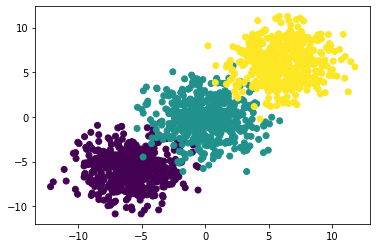

In [3]:
# 生成数据集

# 设置随机数种子
torch.manual_seed(420)

features,labels = tensorGenCla(bias=True,deg_dispersion=[6,2])
plt.scatter(features[:,0],features[:,1],c=labels)

In [4]:
features

tensor([[-6.0141, -4.9911,  1.0000],
        [-4.6593, -6.7657,  1.0000],
        [-5.9395, -5.2347,  1.0000],
        ...,
        [ 6.4622,  4.1406,  1.0000],
        [ 5.7278,  9.2208,  1.0000],
        [ 4.9705,  3.1236,  1.0000]])

In [5]:
# 建模流程

In [9]:
# 模型选择
# 构建只包含一层的神经网络 输入层：两个特征一个bias 输出层：三个分类
# w 行数与输入相关，列数与输出相关 eg: 若w的第一列为 [num1,num2,num3]^T 则 y1 = w1 X1 + w2 X2 +b = num1*X1 + num2*X2 + num3 将一条数据[theX1,theX2,1]代入f*w,得到[y1,y2,y3]在三个类别上的计算结果

def softmax(X,w):
    """softmax
    对所有数据前向传播后的f*w,计算exp() 以第一个数据为例 exp_data1 = [exp(y1),exp(y2),exp(y3)]
    对该条数据exp()计算后的结果求和 sum_data1 = exp(y1) + exp(y2) + exp(y3)
    softmax_data1 = exp_data1 / sum_data1
    对前向传播计算结果进行放缩 [y1,y2,y3] -> [new_y1,new_y2,new_y3]
    """
    m = torch.exp(torch.mm(X,w))
    # torch.sum(m,1),参数1代表对行计算，0为对列计算
    sp = torch.sum(m,1).reshape(-1,1)
    
    return m / sp

In [10]:
# gather / index_select 函数 进行批量索引

In [43]:
ll = torch.tensor([[3,5,6,7,5],[4,8,2,6,3],[3,5,6,7,5],[4,8,2,6,3],[3,5,6,7,5],[4,8,2,6,3]])

# 0 行 1 列

torch.index_select(ll,0,torch.tensor([0,1,3]))
torch.index_select(ll,1,torch.tensor([0,1,3]))

torch.gather(ll,0,torch.tensor([0,1,2]).reshape(-1,1).long())
torch.gather(ll,1,torch.tensor([0,1,2]).reshape(-1,1).long())

tensor([[3, 5, 6, 7, 5],
        [4, 8, 2, 6, 3],
        [4, 8, 2, 6, 3]])

tensor([[3, 5, 7],
        [4, 8, 6],
        [3, 5, 7],
        [4, 8, 6],
        [3, 5, 7],
        [4, 8, 6]])

tensor([[3],
        [4],
        [3]])

tensor([[3],
        [8],
        [6]])

In [51]:
def m_cross_entropy(soft_z,y):
    y = y.long()
    # 每个样本最大分类可能性 eg: soft_z = [[0.6,0.5,0.3],[0.3,0.4,0.2]]  pob_real=[[0.6],[0.4]]
    prob_real = torch.gather(soft_z,1,y)
    # torch.prod(prob_real) = 0.6 * 0.4
    # torch.log(torch.prod(prob_real)) = log(0.6*0.4) = log(0.6) +log(0.4) 先相乘再log，内部取值可能过小可能会log0，因此先log再相加
    return (-(1 / y.numel()) * torch.log(torch.prod(prob_real)))

In [52]:
# 计算交叉熵损失

f = features[:10]
l = labels[:10]
w = torch.arange(9).reshape(3,3).float()

f
l
w

tensor([[-6.0141, -4.9911,  1.0000],
        [-4.6593, -6.7657,  1.0000],
        [-5.9395, -5.2347,  1.0000],
        [-7.0262, -4.5792,  1.0000],
        [-2.3817, -5.1295,  1.0000],
        [-0.7093, -5.4693,  1.0000],
        [-4.1530, -6.8751,  1.0000],
        [-1.9636, -3.3003,  1.0000],
        [-6.5046, -6.0710,  1.0000],
        [-6.1291, -7.1835,  1.0000]])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [55]:
# 方法一
# m_cross_entropy(f,l.reshape(-1,1).long())
m_cross_entropy(softmax(f,w),l)

tensor(0.0021)

In [56]:
# 方法二 nn.CrossEntropyLoss() ，该函数会自动完成softmax过程
criterion = nn.CrossEntropyLoss()
criterion(torch.mm(f,w),l.flatten())

tensor(0.0021)

In [58]:
# 定义优化算法

# 计算准确
def m_accuracy(soft_z, y):
    acc_bool = torch.argmax(soft_z,1).flatten() == y.flatten()
    acc = torch.mean(acc_bool.float())
    
    return (acc)

# 梯度下降
def sgd(params, lr):
    params.data -= lr * params.grad
    params.grad.zero_()

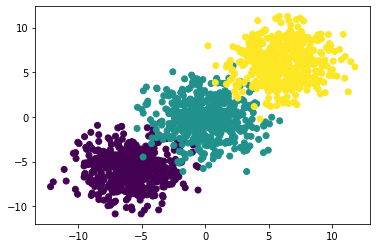

In [59]:
# 训练模型

torch.manual_seed(420)

features,labels = tensorGenCla(bias = True, deg_dispersion = [6,2])
plt.scatter(features[:,0],features[:,1],c=labels)

In [60]:
torch.manual_seed(420)

# 初始化核心参数
batch_size = 10
lr = 0.05
num_epochs = 3
w = torch.randn(3,3,requires_grad=True)

# 参与训练的模型方程
net = softmax
loss = m_cross_entropy

# 模型训练过程
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w),y)
        l.backward()
        sgd(w,lr)
        
    train_acc = m_accuracy(net(features,w),labels)
    print('epoch %d,acc %f' % (epoch + 1, train_acc))

epoch 1,acc 0.925333
epoch 2,acc 0.954667
epoch 3,acc 0.960667


In [61]:
# 查看模型结果
w

tensor([[-0.9398, -0.3273,  0.2850],
        [-0.1729,  0.3690,  0.9543],
        [-0.5993,  2.0995, -0.8482]], requires_grad=True)

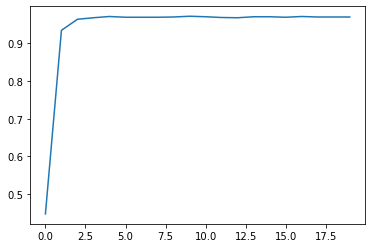

In [64]:
# 模型调试

torch.manual_seed(420)

# 迭代轮数
num_epochs = 20

# 设置初始权重
w = torch.randn(3,3,requires_grad = True)

# 设置列表容器
train_acc = []

# 执行迭代
for i in range(num_epochs):
    # 迭代次数逐渐增加： 1,2,...,19
    for epoch in range(i):
        for X,y in data_iter(batch_size,features,labels):
            l = loss(net(X,w),y)
            l.backward()
            sgd(w,lr)
        
    train_acc.append(m_accuracy(net(features,w),labels))
    
# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)),train_acc)

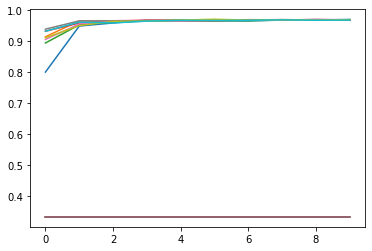

In [65]:
# 取10组不同的w，都迭代10轮，观察其收敛速度 

for i in range(10):
    w = torch.randn(3,3,requires_grad=True)
    train_acc = []
    for epoch in range(10):
        for X,y in data_iter(batch_size,features,labels):
            l = loss(net(X,w),y)
            l.backward()
            sgd(w,lr)
            
        train_acc.append(m_accuracy(net(features,w),labels))
        
    plt.plot(list(range(10)), train_acc)

 ## softmax回归快速实现

In [66]:
# 定义核心参数

batch_size = 10
lr = 0.03
num_epochs = 3

In [70]:
torch.manual_seed(420)

# 创建数据集
features,labels = tensorGenCla(deg_dispersion=[6,2])
labels = labels.float() # 损失函数要求标签也必须是浮点型
data = TensorDataset(features,labels)
batchData = DataLoader(data,batch_size = batch_size,shuffle = True)

In [71]:
features

tensor([[-6.0141, -4.9911],
        [-4.6593, -6.7657],
        [-5.9395, -5.2347],
        ...,
        [ 6.4622,  4.1406],
        [ 5.7278,  9.2208],
        [ 4.9705,  3.1236]])

In [72]:
# 定义模型

class softmaxR(nn.Module):
    def __init__(self,in_features=2,out_features=3,bias=True):
        super(softmaxR,self).__init__()
        
        self.linear = nn.Linear(in_features,out_features)
        
    def forward(self,x):
        out = self.linear(x)
        
        return out
    
# 实例化模型和
softmax_model = softmaxR()

In [73]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()

In [75]:
# 定义优化方法
optimizer = optim.SGD(softmax_model.parameters(),lr=lr)

In [76]:
# 模型训练

def fit(net,criterion,optimizer,batchData,epochs):
    for epoch in range(epochs):
        for X,y in batchData:
            zhat = net.forward(X)
            y = y.flatten().long() # 损失函数计算要求转化为整数
            loss = criterion(zhat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

In [78]:
fit(net = softmax_model,
   criterion = criterion,
   optimizer = optimizer,
   batchData = batchData,
   epochs = num_epochs)

In [79]:
softmax_model # 模型的基本说明

softmaxR(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [81]:
# 查看模型参数
print(list(softmax_model.parameters()))
# 自变量系数矩阵和截距分开训练

[Parameter containing:
tensor([[-0.9994, -0.6402],
        [-0.5057, -0.1928],
        [-0.0249,  0.2833]], requires_grad=True), Parameter containing:
tensor([-0.8582,  1.1191, -1.3036], requires_grad=True)]


In [82]:
# 计算交叉熵损失
criterion(softmax_model(features),labels.flatten().long())

tensor(0.1811, grad_fn=<NllLossBackward>)

In [83]:
# 借助F.softmax函数，计算准确率
m_accuracy(F.softmax(softmax_model(features),1),labels)

tensor(0.9567)

In [84]:
F.softmax(softmax_model(features),1)

tensor([[9.6176e-01, 3.8222e-02, 1.7481e-05],
        [9.6611e-01, 3.3877e-02, 1.2767e-05],
        [9.6433e-01, 3.5654e-02, 1.5051e-05],
        ...,
        [5.8660e-05, 6.5662e-02, 9.3428e-01],
        [1.1672e-06, 8.8285e-03, 9.9117e-01],
        [5.5666e-04, 1.8928e-01, 8.1016e-01]], grad_fn=<SoftmaxBackward>)

In [85]:
# 模型调试
torch.manual_seed(420)

# 创建数据集
features,labels = tensorGenCla(deg_dispersion = [6,2])
labels = labels.float()
data = TensorDataset(features,labels)
batchData = DataLoader(data,batch_size=batch_size,shuffle=True)

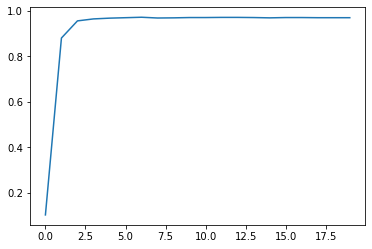

In [86]:
torch.manual_seed(420)

# 初始化核心参数
num_epochs = 20
SF1 = softmaxR()
cr1 = nn.CrossEntropyLoss()
op1 = optim.SGD(SF1.parameters(),lr=lr)

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(num_epochs):
    fit(net = SF1,
       criterion = cr1,
       optimizer = op1,
       batchData = batchData,
       epochs = epochs)
    epoch_acc = m_accuracy(F.softmax(SF1(features),1),labels)
    train_acc.append(epoch_acc)
    
# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)),train_acc)

In [87]:
train_acc

[tensor(0.1033),
 tensor(0.8807),
 tensor(0.9560),
 tensor(0.9647),
 tensor(0.9680),
 tensor(0.9700),
 tensor(0.9720),
 tensor(0.9687),
 tensor(0.9693),
 tensor(0.9707),
 tensor(0.9707),
 tensor(0.9713),
 tensor(0.9713),
 tensor(0.9707),
 tensor(0.9693),
 tensor(0.9707),
 tensor(0.9707),
 tensor(0.9700),
 tensor(0.9700),
 tensor(0.9700)]

In [88]:
# 模型抵达判别效力上限
# 模型逼近损失函数的最小值点，但模型的评估指标（准确率）已经无法继续提升。
# 可以选择多个初始w来观察损失函数是否已经逼近最小值点而不是落在了局部最小值点附近

In [93]:
# 初始化核心参数
cr1 = nn.CrossEntropyLoss()

# 创建列表容器
train_acc = []

# 执行建模
for i in range(10):
    SF1 = softmaxR()
    op1 = optim.SGD(SF1.parameters(),lr=lr)
    fit(net = SF1,
       criterion = cr1,
       optimizer = op1,
       batchData = batchData,
       epochs = 10)
    epoch_acc = m_accuracy(F.softmax(SF1(features),1),labels)
    train_acc.append(epoch_acc)

In [94]:
train_acc

[tensor(0.9687),
 tensor(0.9700),
 tensor(0.9673),
 tensor(0.9680),
 tensor(0.9707),
 tensor(0.9700),
 tensor(0.9680),
 tensor(0.9680),
 tensor(0.9680),
 tensor(0.9680)]

In [95]:
# 准确率没太大变化，模型已经逼近最小值点
# 问题并不是出在损失函数的求解上，而是损失函数本身的构造
# 若要进一步提升模型效果，就要调整模型结构